# 19.1 The Evaluation Challenge

**Chapter**: 19 - Evaluating Causal Models  
**Section**: 1 - The Evaluation Challenge  
**Facure Source**: 19-Evaluating-Causal-Models.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Fundamental Problem](#11-the-fundamental-problem)
   - 1.2 [Why It's Hard](#12-why-its-hard)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [What We Want vs What We Can See](#21-what-we-want-vs-what-we-can-see)
   - 2.2 [Aggregate Estimation](#22-aggregate-estimation)
3. [Setup: Train Causal, Evaluate Causal](#3-setup-train-causal-evaluate-causal)
   - 3.1 [Data Setup](#31-data-setup)
   - 3.2 [Build Candidate Models](#32-build-candidate-models)
4. [Numeric Demonstration](#4-numeric-demonstration)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition

> **Interview Relevance**: Evaluating causal models is a critical skill that distinguishes practitioners from academics. Expect questions about how to validate CATE models in practice.

### 1.1 The Fundamental Problem

In ML, evaluation is straightforward:
1. Train model on train set
2. Predict on test set
3. Compare predictions to actual outcomes

**But for causal inference, what is the "actual outcome"?**

We want to evaluate how good our model is at predicting $\tau_i = Y_i(1) - Y_i(0)$.

But we **never observe both** $Y_i(1)$ and $Y_i(0)$ for the same unit!

```
ML vs Causal Evaluation ─────────────────────────────────

  ML Prediction:
    - Predict Ŷ
    - Compare to actual Y
    - Compute RMSE, R², etc.
    
  Causal (CATE):
    - Predict τ̂(x) = E[Y(1) - Y(0) | X]
    - Compare to... what?
    - τᵢ = Y(1) - Y(0) is NEVER OBSERVED!
─────────────────────────────────────────────────────────
```

### 1.2 Why It's Hard

This is why causal inference is harder to adopt than ML:

- **ML**: Easy to prove your model works ("look at the test set accuracy!")
- **Causal**: How do you convince management your CATE model is good?

Facure calls this the missing piece:

> "It's beyond my comprehension why we don't see any material whatsoever explaining how we should evaluate causal inference models with real data."

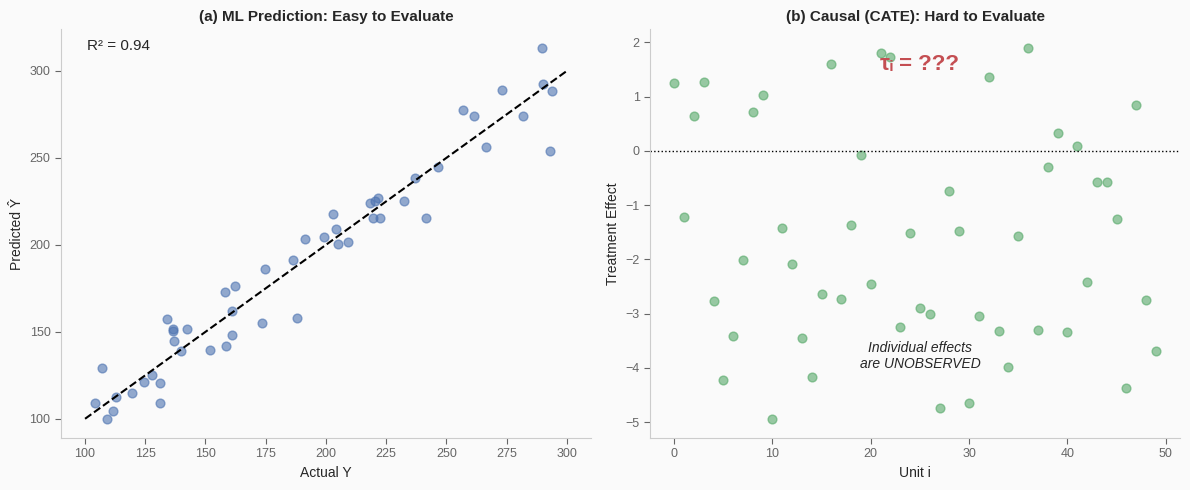


The fundamental problem: We can't compare individual CATE predictions to ground truth!


In [2]:
# Visualize the fundamental problem
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: ML evaluation (easy)
ax = axes[0]
np.random.seed(42)
y_true = np.random.uniform(100, 300, 50)
y_pred = y_true + np.random.normal(0, 15, 50)
ax.scatter(y_true, y_pred, alpha=0.6, s=40, c=COLORS['blue'])
ax.plot([100, 300], [100, 300], 'k--', lw=1.5, label='Perfect')
ax.set_xlabel('Actual Y')
ax.set_ylabel('Predicted Ŷ')
ax.set_title('(a) ML Prediction: Easy to Evaluate', fontweight='bold')
r2 = 1 - np.var(y_pred - y_true) / np.var(y_true)
ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, fontsize=11)

# Panel 2: Causal evaluation (hard)
ax = axes[1]
tau_pred = np.random.uniform(-5, 2, 50)
ax.scatter(np.arange(50), tau_pred, alpha=0.6, s=40, c=COLORS['green'], label='τ̂(x) predicted')
ax.axhline(0, color='black', ls=':', lw=1)
ax.text(25, 1.5, 'τᵢ = ???', fontsize=16, ha='center', fontweight='bold', color=COLORS['red'])
ax.text(25, -4, 'Individual effects\nare UNOBSERVED', fontsize=10, ha='center', style='italic')
ax.set_xlabel('Unit i')
ax.set_ylabel('Treatment Effect')
ax.set_title('(b) Causal (CATE): Hard to Evaluate', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nThe fundamental problem: We can't compare individual CATE predictions to ground truth!")

---

## 2. Formal Treatment

### 2.1 What We Want vs What We Can See

**What we want to evaluate**:
$$\text{Error}_i = \hat{\tau}(X_i) - \tau_i = \hat{\tau}(X_i) - [Y_i(1) - Y_i(0)]$$

**What we observe**:
$$Y_i = T_i \cdot Y_i(1) + (1-T_i) \cdot Y_i(0)$$

We only see **one** potential outcome — not both!

### 2.2 Aggregate Estimation

**The key insight**: While we can't see individual $\tau_i$, we CAN estimate **aggregate** treatment effects for groups.

If treatment is randomized within a group, then:

$$\hat{\tau}_{group} = \bar{Y}_{treated} - \bar{Y}_{control}$$

This is unbiased for the ATE in that group!

**Evaluation strategy**:
1. Use CATE model to create groups (bands)
2. Estimate actual treatment effect within each band
3. Good model → bands have **different** treatment effects
4. Random model → all bands have **same** treatment effect (≈ overall ATE)

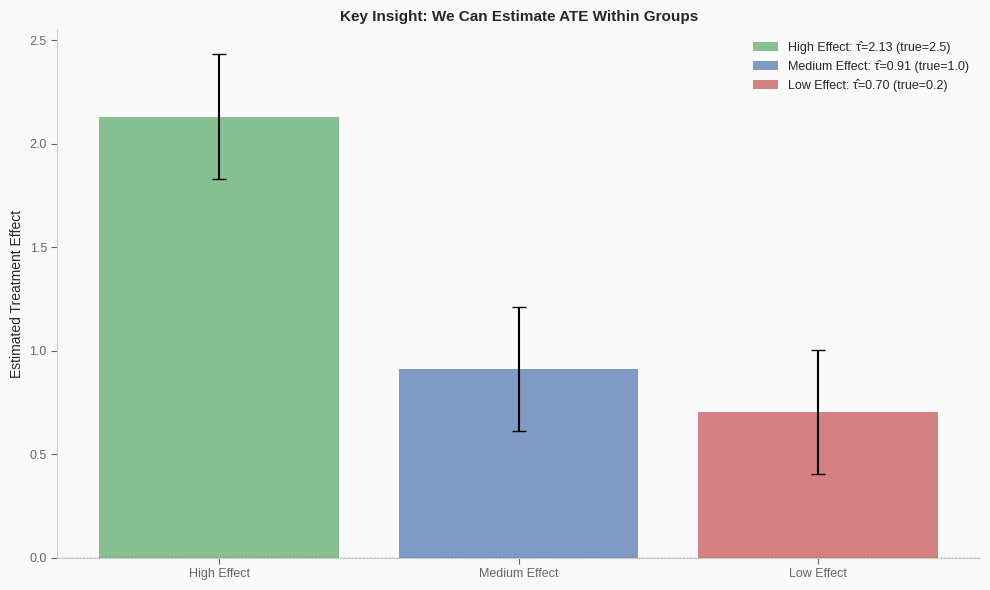


If a CATE model creates these groups, we can verify the groups have different effects!


In [3]:
# Visualize aggregate vs individual estimation
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

# Simulate group-level estimation
np.random.seed(42)
n_per_group = 100

# Three groups with different true CATEs
groups = [
    ('High Effect', 2.5, COLORS['green']),
    ('Medium Effect', 1.0, COLORS['blue']),
    ('Low Effect', 0.2, COLORS['red'])
]

x_pos = 0
for name, true_tau, color in groups:
    # Simulate randomized data in this group
    T = np.random.binomial(1, 0.5, n_per_group)
    Y0 = np.random.normal(10, 2, n_per_group)
    Y1 = Y0 + true_tau + np.random.normal(0, 0.5, n_per_group)
    Y = T * Y1 + (1-T) * Y0
    
    # Estimate treatment effect
    tau_hat = Y[T==1].mean() - Y[T==0].mean()
    
    # Plot
    ax.bar(x_pos, tau_hat, width=0.8, color=color, alpha=0.7, 
           label=f'{name}: τ̂={tau_hat:.2f} (true={true_tau})')
    ax.errorbar(x_pos, tau_hat, yerr=0.3, fmt='none', color='black', capsize=5)
    x_pos += 1

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['High Effect', 'Medium Effect', 'Low Effect'])
ax.set_ylabel('Estimated Treatment Effect')
ax.set_title('Key Insight: We Can Estimate ATE Within Groups', fontweight='bold')
ax.axhline(0, color='black', ls=':', lw=1)
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

print("\nIf a CATE model creates these groups, we can verify the groups have different effects!")

---

## 3. Implementation: Train Causal, Evaluate Causal

Our evaluation strategy:
1. Train models on **non-random** data (observational)
2. Evaluate on **random** data (where ATE estimation is valid)

This is realistic: random data is expensive, so we save it for evaluation.

### 3.1 Data Setup

In [4]:
# Load data
# Non-random: for training (observational)
# Random: for evaluation (prices randomized)
prices = load_facure_data('ice_cream_sales.csv')  # Non-random
prices_rnd = load_facure_data('ice_cream_sales_rnd.csv')  # Random

print("=" * 60)
print("DATA SETUP")
print("=" * 60)
print(f"\nTraining (non-random): {len(prices):,} observations")
print(f"Evaluation (random):   {len(prices_rnd):,} observations")

print("\nNon-random data (price correlates with other factors):")
print(prices[['temp', 'price', 'sales']].corr().round(3))

print("\nRandom data (price is randomized):")
print(prices_rnd[['temp', 'price', 'sales']].corr().round(3))

DATA SETUP

Training (non-random): 10,000 observations
Evaluation (random):   5,000 observations

Non-random data (price correlates with other factors):
         temp   price  sales
temp   1.0000 -0.0040 0.3760
price -0.0040  1.0000 0.0760
sales  0.3760  0.0760 1.0000

Random data (price is randomized):
        temp   price   sales
temp  1.0000  0.0140  0.3820
price 0.0140  1.0000 -0.2750
sales 0.3820 -0.2750  1.0000


### 3.2 Build Candidate Models

In [5]:
# Model 1: CATE model (regression with interactions)
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

# Model 2: Predictive model (ML, no causal structure)
X = ["temp", "weekday", "cost", "price"]
y = "sales"
m2 = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=42)
m2.fit(prices[X], prices[y])

# Model 3: Random model (baseline)
# Predictions are random numbers

print("Models trained:")
print("  M1: CATE model (regression with interactions)")
print("  M2: Predictive model (GradientBoosting)")
print("  M3: Random model (baseline)")

Models trained:
  M1: CATE model (regression with interactions)
  M2: Predictive model (GradientBoosting)
  M3: Random model (baseline)


In [6]:
# Generate predictions on random (evaluation) data
def predict_sensitivity(model, df, h=0.01):
    """Numerical derivative approximation for sensitivity."""
    df_plus = df.copy()
    df_plus['price'] = df['price'] + h
    return (model.predict(df_plus) - model.predict(df)) / h

prices_rnd_pred = prices_rnd.copy()
prices_rnd_pred['sensitivity_m_pred'] = predict_sensitivity(m1, prices_rnd)
prices_rnd_pred['pred_m_pred'] = m2.predict(prices_rnd[X])
prices_rnd_pred['rand_m_pred'] = np.random.uniform(size=len(prices_rnd))

print("Predictions added to evaluation data:")
print(prices_rnd_pred[['temp', 'price', 'sales', 
                       'sensitivity_m_pred', 'pred_m_pred', 'rand_m_pred']].head())

Predictions added to evaluation data:
     temp  price  sales  sensitivity_m_pred  pred_m_pred  rand_m_pred
0 25.8000      7    230            -13.0970     226.8419       0.2183
1 22.7000      4    190              1.0547     189.9825       0.9500
2 33.7000      5    237            -17.3626     234.8865       0.7863
3 23.0000      5    193              0.5650     186.5668       0.0894
4 24.4000      3    252            -13.7179     243.4797       0.4176


---

## 4. Numeric Demonstration

Let's verify we have sensible predictions before moving to evaluation.

In [7]:
# Summary of predictions
print("=" * 60)
print("PREDICTION SUMMARY")
print("=" * 60)

for col, name in [('sensitivity_m_pred', 'CATE Model'), 
                   ('pred_m_pred', 'Predictive Model'),
                   ('rand_m_pred', 'Random Model')]:
    print(f"\n{name}:")
    print(f"  Mean: {prices_rnd_pred[col].mean():.3f}")
    print(f"  Std:  {prices_rnd_pred[col].std():.3f}")
    print(f"  Min:  {prices_rnd_pred[col].min():.3f}")
    print(f"  Max:  {prices_rnd_pred[col].max():.3f}")

PREDICTION SUMMARY

CATE Model:
  Mean: -4.012
  Std:  6.260
  Min:  -18.777
  Max:  5.565

Predictive Model:
  Mean: 201.222
  Std:  20.211
  Min:  141.376
  Max:  253.102

Random Model:
  Mean: 0.498
  Std:  0.289
  Min:  0.000
  Max:  1.000


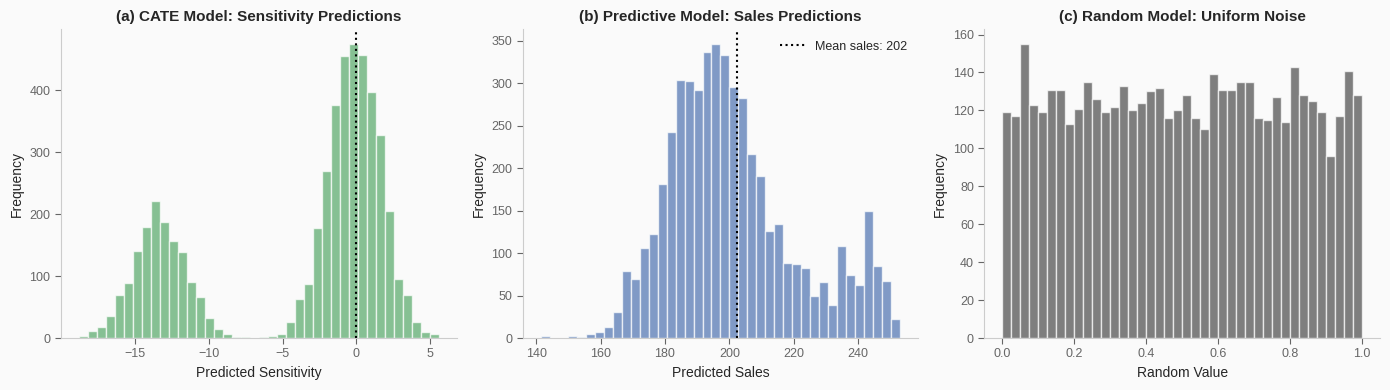

In [8]:
# Visualize the predictions
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: CATE predictions
ax = axes[0]
ax.hist(prices_rnd_pred['sensitivity_m_pred'], bins=40, color=COLORS['green'], 
        alpha=0.7, edgecolor='white')
ax.axvline(0, color='black', ls=':', lw=1.5)
ax.set_xlabel('Predicted Sensitivity')
ax.set_ylabel('Frequency')
ax.set_title('(a) CATE Model: Sensitivity Predictions', fontweight='bold')

# Panel 2: Predictive model
ax = axes[1]
ax.hist(prices_rnd_pred['pred_m_pred'], bins=40, color=COLORS['blue'], 
        alpha=0.7, edgecolor='white')
ax.axvline(prices_rnd_pred['sales'].mean(), color='black', ls=':', lw=1.5,
          label=f'Mean sales: {prices_rnd_pred["sales"].mean():.0f}')
ax.set_xlabel('Predicted Sales')
ax.set_ylabel('Frequency')
ax.set_title('(b) Predictive Model: Sales Predictions', fontweight='bold')
ax.legend(frameon=False)

# Panel 3: Random model
ax = axes[2]
ax.hist(prices_rnd_pred['rand_m_pred'], bins=40, color=TUFTE_PALETTE['primary'], 
        alpha=0.7, edgecolor='white')
ax.set_xlabel('Random Value')
ax.set_ylabel('Frequency')
ax.set_title('(c) Random Model: Uniform Noise', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# The key question: Which model creates the best segments?
print("=" * 60)
print("THE EVALUATION QUESTION")
print("=" * 60)
print("""
We have three models with different predictions.

The question: Which one best segments units by ACTUAL treatment effect?

To answer this, we need to:
1. Create bands (segments) from each model's predictions
2. Estimate actual treatment effect in each band
3. Better model = bands with MORE DIFFERENT treatment effects

This is what we'll cover in the next notebooks:
- 02: Sensitivity by band (visual evaluation)
- 03: Cumulative gain curves (quantitative evaluation)
""")

THE EVALUATION QUESTION

We have three models with different predictions.

The question: Which one best segments units by ACTUAL treatment effect?

To answer this, we need to:
1. Create bands (segments) from each model's predictions
2. Estimate actual treatment effect in each band
3. Better model = bands with MORE DIFFERENT treatment effects

This is what we'll cover in the next notebooks:
- 02: Sensitivity by band (visual evaluation)
- 03: Cumulative gain curves (quantitative evaluation)



```
Key Takeaways ───────────────────────────────────────────

1. Individual CATE is unobservable
   - Can't compute τ̂(x) - τᵢ directly
   - No simple ground truth for evaluation

2. But aggregate ATE IS estimable
   - With randomized data: ATE = Ȳ(1) - Ȳ(0)
   - Can estimate within any subgroup!

3. Evaluation strategy
   - Create bands from model predictions
   - Estimate actual ATE within each band
   - Good model → bands have different ATEs
   
4. Setup
   - Train on observational data (abundant)
   - Evaluate on randomized data (precious)
─────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"How do you evaluate a CATE model when you can't observe individual treatment effects?"*

<details>
<summary>Solution</summary>

**The challenge**: Individual $\tau_i = Y_i(1) - Y_i(0)$ is never observed.

**The solution**: Evaluate at the **group level**.

1. **Create bands** from CATE predictions:
   - Sort units by predicted $\hat{\tau}(x)$
   - Split into quantiles (e.g., high/medium/low)

2. **Estimate actual ATE** in each band:
   - With randomized data: $\hat{\tau}_{band} = \bar{Y}_{T=1} - \bar{Y}_{T=0}$
   - This is unbiased for the true ATE in that band

3. **Compare bands**:
   - Good model: Bands have different treatment effects
   - Random model: All bands have same ATE (≈ overall ATE)

**Key requirement**: Need randomized data for evaluation (or valid causal identification).

**Metrics**:
- Sensitivity by band plots
- Cumulative gain curves
- AUUC (Area Under Uplift Curve)

</details>

---

**Q2 (Amazon L6, Econ)**: *"Why do we need randomized data to evaluate CATE models?"*

<details>
<summary>Solution</summary>

**The core issue**: Evaluating CATE requires estimating actual treatment effects in subgroups.

**With randomized data**:
- Treatment is independent of potential outcomes: $(Y(0), Y(1)) \perp T$
- Simple difference is unbiased: $E[Y|T=1] - E[Y|T=0] = E[Y(1) - Y(0)]$
- Works within any subgroup defined by X

**Without randomization**:
- Confounding: $E[Y|T=1] - E[Y|T=0] \neq E[Y(1) - Y(0)]$
- Need to control for confounders
- But: controlling for confounders in evaluation is tricky
- Risk of overfitting the evaluation itself

**Practical setup**:
- Observational data is abundant → use for training
- Randomized data is expensive → save for evaluation
- Even a small randomized holdout is valuable

**Alternative**: If no randomized data, use synthetic data or A/B tests.

</details>

---

**Q3 (Google L5, Quant)**: *"What's wrong with using prediction accuracy (R², RMSE) to evaluate CATE models?"*

<details>
<summary>Solution</summary>

**The problem**: Prediction accuracy ≠ treatment effect accuracy.

1. **Different targets**:
   - R² measures how well you predict Y
   - CATE measures how Y changes with T
   - A model can predict Y well but miss the causal effect

2. **Example**:
   - Model A: R² = 0.95, but ignores treatment entirely
   - Model B: R² = 0.80, but captures treatment heterogeneity
   - Model A has better R² but is useless for treatment decisions!

3. **What we need to evaluate**:
   - Not: "Does the model predict Y well?"
   - But: "Does the model separate units by treatment effect?"

4. **Correct evaluation**:
   - Create bands from model predictions
   - Check if bands have different actual treatment effects
   - Use cumulative gain curves, not R²

**Analogy**: Evaluating a weather model by how well it predicts temperature doesn't tell you if it captures how temperature affects umbrella sales.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 19: "Evaluating Causal Models."

[^2]: Gutierrez, P. and Gérardy, J. Y. (2017). Causal Inference and Uplift Modeling: A Review of the Literature. *JMLR Workshop and Conference Proceedings*, 67, 1-13.

[^3]: Athey, S. and Imbens, G. W. (2016). Recursive partitioning for heterogeneous causal effects. *PNAS*, 113(27), 7353-7360.

[^4]: Radcliffe, N. J. (2007). Using Control Groups to Target on Predicted Lift. *Direct Market Journal*, 3, 14-21.

---

**Next**: [02. Sensitivity by Band](./02_sensitivity_by_band.ipynb) — Visual evaluation of CATE models